# 1) Calculate tendency of SST and and SSS from mixing

In [2]:
import xarray as xr
import numpy as np
import dask.array as dsa
import matplotlib.pyplot as plt
from fastjmd95 import jmd95numba

In [3]:
from intake import open_catalog
url = "https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean/CESM_POP.yaml"
cat = open_catalog(url)
ds  = cat["CESM_POP_hires_control"].to_dask()

In [4]:
ds

<xarray.Dataset>
Dimensions:             (nlat: 2400, nlon: 3600, time: 14965, z_t: 62, z_w: 62,
                         z_t_150m: 15, z_w_bot: 62, z_w_top: 62)
Coordinates: (12/59)
    ANGLE               (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ANGLET              (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DXU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYT                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    DYU                 (nlat, nlon) float64 dask.array<chunksize=(2400, 3600), meta=np.ndarray>
    ...                  ...
    vonkar              float64 ...
  * z_t                 (z_t) float32 500.0 1.5e+03 ... 5.625e+05 5.875e+05
  * z_t_150m            (z_t_150m) float32 500.0 1.5e+03 ... 1.35e+04 1.45e+04
  * z_w                 (z_w) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
  * z_w_bot             (z_w_bot) float32 1e+03 2e+03 3e+03 ... 5.75e+05 6e+05
  * z_w_top             (z_w_top) float32 0.0 1e+03 2e+03 ... 5.5e+05 5.75e+05
Dimensions without coordinates: nlat, nlon
Data variables:
    HMXL_2              (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SFWF_2              (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SHF_2               (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SSH_2               (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SSS                 (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    SST                 (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    TAUX_2              (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    TAUY_2              (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    U1_1                (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    U2_2                (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    V1_1                (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
    V2_2                (time, nlat, nlon) float32 dask.array<chunksize=(1, 2400, 3600), meta=np.ndarray>
Attributes:
    Conventions:   CF-1.0; http://www.cgd.ucar.edu/cms/eaton/netcdf/CF-curren...
    calendar:      All years have exactly  365 days.
    cell_methods:  cell_methods = time: mean ==> the variable values are aver...
    contents:      Diagnostic and Prognostic Variables
    history:       none
    nsteps_total:  13088337
    revision:      $Id: tavg.F90 41939 2012-11-14 16:37:23Z mlevy@ucar.edu $
    source:        CCSM POP2, the CCSM Ocean Component
    start_time:    This dataset was created on 2013-03-09 at 12:25:55.7
    tavg_sum:      86399.99999999962
    title:         hybrid_v5_rel04_BC5_ne120_t12_pop62

In [5]:
#from Paige's code: The biharmonic horiz diffusion routine
#https://github.com/ocean-transport/cesm-air-sea/blob/master/biharmonic_tendency.ipynb

# raw grid geometry
work1 = (ds['HTN'].values / # HTN: cell widths on North sides of T cell (cm)
         ds['HUW'].values) # HUW: cell widths on West sides of U cell (cm)
tarea = ds['TAREA'].values # TAREA: area of T cells (cm**2)
tarea_r = np.ma.masked_invalid(tarea**-1).filled(0.) # 1/area of T cells
dtn = work1*tarea_r # coefficient of north point in 5-point stencil
dts = np.roll(work1,-1,axis=0)*tarea_r # coeff of south point in 5-point stencil

work1 = (ds['HTE'].values / # HTE: cell widths on East sides of T cells (cm)
         ds['HUS'].values) # HUS: cell widths on South sides of U cells (cm)
dte = work1*tarea_r # coeff of east point in 5-point stencil
dtw = np.roll(work1,-1,axis=1)*tarea_r # coeff of west point in 5-point stencil

kmt = ds['KMT'].values # KMT: k-index of deepest grid cell on T grid (where k is the depth level)

# boundary conditions
kmt_ = kmt > 1 # k=1 is the surface, so this sets all subsurface levels to True
kmtn = np.roll(kmt_,-1,axis=0)
kmts = np.roll(kmt_,1,axis=0)
kmte = np.roll(kmt_,-1,axis=1)
kmtw = np.roll(kmt_,1,axis=1)
cn = np.where(kmt_ & kmtn, dtn, 0.) # where both kmt_ and kmtn are True, set value equal to dtn, else set to 0 -->
# --> essentially sets up a mask for land/surface points
cs = np.where(kmt_ & kmts, dts, 0.)
ce = np.where(kmt_ & kmte, dte, 0.)
cw = np.where(kmt_ & kmtw, dtw, 0.)

# Find single index where there's a min of squared latitude --> so this is probably the lat of equator
j_eq = np.argmin(ds['ULAT'].values[:,0]**2) # ULAT: array of U-grid latitudes (degrees North)
j_eq.shape

# Area of T cells / area of U cell at the equator, all raised to 1.5 power
# this is because the mixing scheme assumes the grid spacing that is at the equator, so coeffs are 1 at equator and reduce toward the poles
ahf = (tarea / ds['UAREA'].values[j_eq, 0])**1.5 # UAREA: area of U cells (cm**2)
ahf[kmt <= 1] = 0.

def laplacian(T, cn, cs, ce, cw):
    cc = -(cn + cs + ce + cw) # cn,cs,ce,cw are coeffs for laplacian
    return (
        cc * T +
        cn * np.roll(T, -1, axis=-2) +
        cs * np.roll(T, 1, axis=-2) +
        ce * np.roll(T, -1, axis=-1) +
        cw * np.roll(T, 1, axis=-1)          
    )

def biharmonic_tendency(T, ahf, cn, cs, ce, cw):
    ah=-3e17 # horizontal tracer mixing coefficient 
    d2tk = ahf * laplacian(T, cn, cs, ce, cw) # take laplacian of T, multiplying by grid factor due to equator
    return ah * laplacian(d2tk, cn, cs, ce, cw) # take laplacian of laplacian of T

/tmp/ipykernel_554/320061692.py:37: RuntimeWarning: invalid value encountered in power
  ahf = (tarea / ds['UAREA'].values[j_eq, 0])**1.5 # UAREA: area of U cells (cm**2)


In [6]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [21]:
client.close()
cluster.close()

In [ ]:
arr = [ahf, cn, cs, ce, cw]
for arr_type in arr:
    if str(type(arr_type)) == "<class 'numpy.ndarray'>":
        print("True")
    else:
        print("not ndarray")


In [1]:
from dask_gateway import Gateway
from dask.distributed import Client

#g = Gateway()
#c = g.list_clusters()[0]
#cluster = g.connect(c.name)
#client = Client(cluster)
#client

gateway = Gateway()
options = gateway.cluster_options()
options.worker_memory=20
cluster2 = gateway.new_cluster(options)
cluster2.adapt(minimum=1,maximum=30)
client2 = Client(cluster2)

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [7]:
client2 = client
cluster2 = cluster

In [20]:
client2.close()
cluster2.close()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:1013: RuntimeWarning: coroutine 'rpc.close_rpc' was never awaited
  self.scheduler_comm.close_rpc()


In [8]:
futures = client2.scatter([ahf, cn, cs, ce, cw], broadcast=True) # this sends all these coeffs to all workers in distributed memory

In [9]:
futures

[<Future: finished, type: numpy.ndarray, key: ndarray-60a89c8c3775aacc3721ab897681c29b>,
 <Future: finished, type: numpy.ndarray, key: ndarray-6be0ba98468731fbceff7354883e68a3>,
 <Future: finished, type: numpy.ndarray, key: ndarray-bdbebafd4822b7ba9a8e7329819e395c>,
 <Future: finished, type: numpy.ndarray, key: ndarray-dcf68361c8db2422082b715a5bd6c9c5>,
 <Future: finished, type: numpy.ndarray, key: ndarray-827369cef22b41d23be42d3ff302e173>]

In [9]:
SST_bih = xr.DataArray(
    dsa.map_blocks(biharmonic_tendency, ds.SST.data, *futures, 
                   dtype=ds.SST.data.dtype),
    dims=ds.SST.dims,
    coords=ds.SST.reset_coords(drop=True).coords
)
SST_bih

<xarray.DataArray 'biharmonic_tendency-b67ff4de522ed8b01402b79efaa0bdb8' (
                                                                          time: 14965,
                                                                          nlat: 2400,
                                                                          nlon: 3600)>
dask.array<biharmonic_tendency, shape=(14965, 2400, 3600), dtype=float32, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Dimensions without coordinates: nlat, nlon

In [10]:
SSS_bih = xr.DataArray(
    dsa.map_blocks(biharmonic_tendency, ds.SSS.data, *futures, 
                   dtype=ds.SSS.data.dtype),
    dims=ds.SSS.dims,
    coords=ds.SSS.reset_coords(drop=True).coords
)
SSS_bih

<xarray.DataArray 'biharmonic_tendency-3a189375b12bb5a554d332ff69bff393' (
                                                                          time: 14965,
                                                                          nlat: 2400,
                                                                          nlon: 3600)>
dask.array<biharmonic_tendency, shape=(14965, 2400, 3600), dtype=float32, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Dimensions without coordinates: nlat, nlon

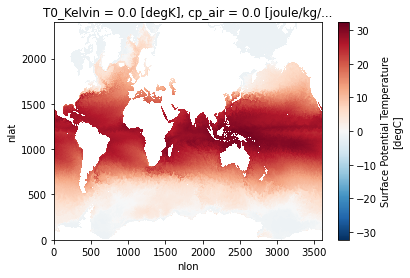

In [12]:
ds.SST[0].plot()

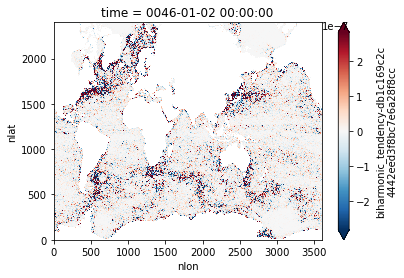

In [13]:
SST_bih[0].plot(robust=True);

# 2) Convert to density tendency

$$
\frac{\partial \rho}{\partial \theta} M(\theta) + \frac{\partial \rho}{\partial S} M(S)
$$

$$
\\ where \\ \alpha = \frac{\partial \rho}{\partial \theta} \ , \ \beta = \frac{\partial \rho}{\partial S}
$$

In [ ]:
ds

In [11]:
#for a single timestep to save computation cost
sst = ds.SST[0]
sss = ds.SSS[0]

In [12]:
runit2mass = 1.035e3 #rho_0

drhodt = xr.apply_ufunc(jmd95numba.drhodt, sss, sst, 0,
                        output_dtypes=[sst.dtype],
                        dask='parallelized').reset_coords(drop=True).load()
drhods = xr.apply_ufunc(jmd95numba.drhods, sss, sst, 0,
                        output_dtypes=[sss.dtype],
                        dask='parallelized').reset_coords(drop=True).load()

alpha = - drhodt / runit2mass
beta = drhods / runit2mass

$$
\frac{\partial \rho}{\partial \theta} M(\theta) + \frac{\partial \rho}{\partial S} M(S)
$$


In [ ]:
SST_bih

In [13]:
dens_tend = alpha * SST_bih[0] + beta * SSS_bih[0]
dens_tend

<xarray.DataArray (nlat: 2400, nlon: 3600)>
dask.array<add, shape=(2400, 3600), dtype=float64, chunksize=(2400, 3600), chunktype=numpy.ndarray>
Coordinates:
    time     object 0046-01-02 00:00:00
Dimensions without coordinates: nlat, nlon

In [ ]:
dens_tend.plot(robust=True);

# 3) Decompose into the following form

$$
\frac{\partial \rho}{\partial \theta} M(\theta) + \frac{\partial \rho}{\partial S} M(S) = M(\rho) + C
$$

You can calculate $C$ as

$$
C = \frac{\partial \rho}{\partial \theta} M(\theta) + \frac{\partial \rho}{\partial S} M(S) - M(\rho)
$$

In [14]:
rho = xr.apply_ufunc(jmd95numba.rho, ds.SSS, ds.SST, 0,
                        output_dtypes=[ds.SST.dtype],
                        dask='parallelized').reset_coords(drop=True)#.load())

In [15]:
rho

<xarray.DataArray (time: 14965, nlat: 2400, nlon: 3600)>
dask.array<transpose, shape=(14965, 2400, 3600), dtype=float32, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Dimensions without coordinates: nlat, nlon

In [16]:
rho_bih = xr.DataArray(dsa.map_blocks(biharmonic_tendency, rho.data, *futures, 
                                      dtype=rho.data.dtype),
                       dims=rho.dims,
                       coords=rho.reset_coords(drop=True).coords)

rho_bih

<xarray.DataArray 'biharmonic_tendency-2598718e3523c640ea6bbd6e7ba0282a' (
                                                                          time: 14965,
                                                                          nlat: 2400,
                                                                          nlon: 3600)>
dask.array<biharmonic_tendency, shape=(14965, 2400, 3600), dtype=float32, chunksize=(1, 2400, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Dimensions without coordinates: nlat, nlon

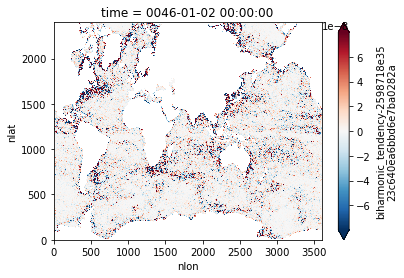

In [17]:
rho_bih[0].plot(robust=True);

In [18]:
cabbeling = dens_tend - rho_bih

In [30]:
cabbeling

<xarray.DataArray (nlat: 2400, nlon: 3600, time: 14965)>
dask.array<sub, shape=(2400, 3600, 14965), dtype=float64, chunksize=(2400, 3600, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 0046-01-02 00:00:00 ... 0087-01-01 00:00:00
Dimensions without coordinates: nlat, nlon

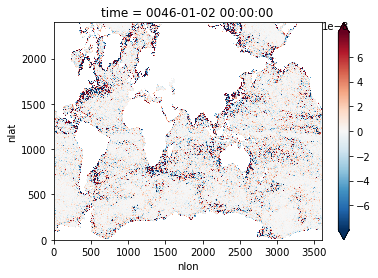

In [31]:
cabbeling.isel(time=0).plot(robust=True);

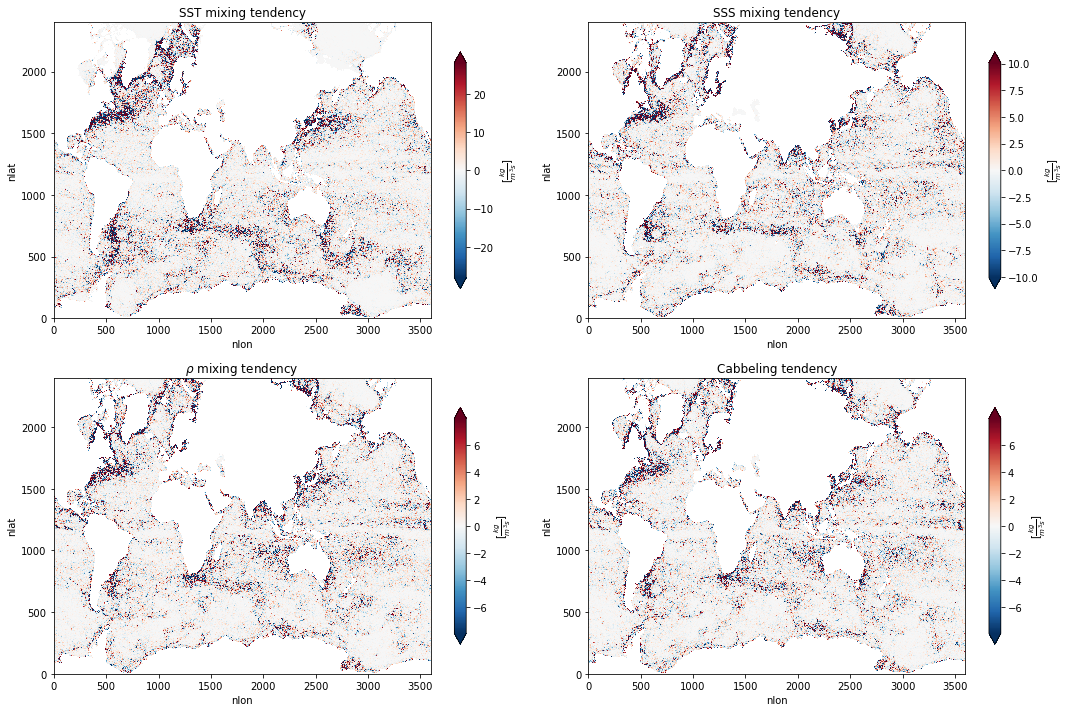

In [19]:
#plot all four terms
fig, ax = plt.subplots(2,2, figsize=(15,10))

(SST_bih/1e-8).isel(time=0).plot(robust=True, ax=ax[0,0], 
                                 cbar_kwargs={'shrink': 0.8, 'label':r'[$\frac{kg}{m^3 s}$]'})
ax[0,0].set_title('SST mixing tendency')
(SSS_bih/1e-8).isel(time=0).plot(robust=True, ax=ax[0,1], 
                                 cbar_kwargs={'shrink': 0.8, 'label':r'[$\frac{kg}{m^3 s}$]'})
ax[0,1].set_title('SSS mixing tendency')
(rho_bih/1e-8).isel(time=0).plot(robust=True, ax=ax[1,0], 
                                 cbar_kwargs={'shrink': 0.8, 'label':r'[$\frac{kg}{m^3 s}$]'})
ax[1,0].set_title(r'$\rho$ mixing tendency')
(cabbeling/1e-8).isel(time=0).plot(robust=True, ax=ax[1,1], 
                                   cbar_kwargs={'shrink': 0.8, 'label':r'[$\frac{kg}{m^3 s}$]'})
ax[1,1].set_title('Cabbeling tendency')

plt.tight_layout();